In [23]:
#               __  ___  _      __                ___              _     ___                    _      ___     _            _   _             
#              /__\/   \/_\    / _| ___  _ __    / __\__ _ _ __ __| |   / __\ __ __ _ _   _  __| |    /   \___| |_ ___  ___| |_(_) ___  _ __  
#             /_\ / /\ //_\\  | |_ / _ \| '__|  / /  / _` | '__/ _` |  / _\| '__/ _` | | | |/ _` |   / /\ / _ \ __/ _ \/ __| __| |/ _ \| '_ \ 
#            //__/ /_//  _  \ |  _| (_) | |    / /__| (_| | | | (_| | / /  | | | (_| | |_| | (_| |  / /_//  __/ ||  __/ (__| |_| | (_) | | | |
#            \__/___,'\_/ \_/ |_|  \___/|_|    \____/\__,_|_|  \__,_| \/   |_|  \__,_|\__,_|\__,_| /___,' \___|\__\___|\___|\__|_|\___/|_| |_|

Credit Card Fraud Detection is a classic class-imbalance problem where the number of fraud transactions is much lesser than the number of legitimate transaction for any bank. Most of the approaches involve building model on such imbalanced data, and thus fails to produce results on real-time new data because of overfitting on training data and a bias towards the majoritarian class of legitimate transactions. Thus, we can see this as an anomaly detection problem.

1. What time does the Credit Card Frauds usually take place?
2. What are the general trends of amounts for Credit Card Fraud Transactions?
3. How do we balance the data to not let the model overfit on legitimate transactions?

In [24]:
# Libraries are imported.
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import csv

In [25]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> Data pre-processing <-------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
# Reading the file.
df_train = pd.read_csv('/Users/alejandro/Desktop/Life/Credit-Card-Fraud-Detection/Datasets/training.csv', delimiter=',', quotechar='"', error_bad_lines=False, encoding='utf-8')

/var/folders/1p/27jszvps12x14r9hnwf07w240000gn/T/ipykernel_88371/3751845789.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_train = pd.read_csv('/Users/alejandro/Desktop/Life/Credit-Card-Fraud-Detection/Datasets/training.csv', delimiter=',', quotechar='"', error_bad_lines=False, encoding='utf-8')
Skipping line 99069: expected 24 fields, saw 45
Skipping line 120702: expected 24 fields, saw 45

Skipping line 145084: expected 24 fields, saw 45
Skipping line 151910: expected 24 fields, saw 45
Skipping line 162210: expected 24 fields, saw 45

Skipping line 327913: expected 24 fields, saw 32
Skipping line 330011: expected 24 fields, saw 45

Skipping line 497019: expected 24 fields, saw 45

Skipping line 649066: expected 24 fields, saw 45

Skipping line 673156: expected 24 fields, saw 32
Skipping line 681350: expected 24 fields, saw 45

Skipping line 720422: expected 24 fields, saw 45

Skippi

In [27]:
# The first 10 rows were printed.
print(df_train.head(10))

  Unnamed: 0 trans_date_trans_time                 cc_num  \
0    1123078   2020-04-12 21:54:18       30273037698427.0   
1     633617   2019-09-26 22:00:19  4906628655840914432.0   
2     259995   2020-09-25 01:02:28     3533800906065217.0   
3     976282   2020-01-31 13:26:26         571365235126.0   
4    1048650   2020-03-10 16:43:00     6011367958204270.0   
5     227122   2020-09-10 15:55:13       38295635583927.0   
6     533391   2020-12-27 10:57:20     2266735643685262.0   
7     908233   2019-12-28 19:14:11        4481131401752.0   
8      69507   2019-02-10 23:36:05     4800395067176717.0   
9      46760   2020-07-07 04:41:15     3521815216091574.0   

                      merchant        category     amt    first       last  \
0           fraud_Connelly PLC     food_dining    1.34   Andrew  Patterson   
1            fraud_Gerlach Inc    shopping_net    9.62  Charles     Moreno   
2              fraud_Price Inc    shopping_net   45.17    Amber   Thornton   
3          fraud

In [28]:
# The columns were printed.
print(df_train.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'Link'],
      dtype='object')


In [29]:
# First it is necessary to drop all the duplicate values. Although, the shell script is in charge of that.
df_train = df_train.copy()
df_train.drop_duplicates(inplace = True)
print("Duplicated values dropped successfully")

Duplicated values dropped successfully


In [30]:
# Some columns get renamed.
df_train.rename(columns = {'trans_date_trans_time':'transaction_time',
                         'cc_num':'credit_card_number',
                         'amt':'amount(usd)',
                         'trans_num':'transaction_id'},
                inplace = True)

In [31]:
# The datetime columns were converted.
# transaction_time and dob should be in pd.datetime format and we also convert unix_time to exact timestamp
df_train['transaction_time'] = pd.to_datetime(df_train['transaction_time'], infer_datetime_format = True)
df_train['dob'] = pd.to_datetime(df_train['dob'], infer_datetime_format = True)

ParserError: Unknown string format: cÔ¡æ>1HÇÕdì³)e>e<E_Ö<e%Ä>ñâû×HËY¥Uu´7Ùmâ?Já¥`Ó`¤µ÷ïvºbsÔÉ¦§+»ó¼:Uÿ5kPÚG9àYàkÕ_DSg3`4ëeÏ®ºx­ä{~£OnÁÓHµÔAi¡ý]û¦PövrÃ2¨ÛYÄðè7®/" present at position 824

In [ ]:
# A function was applied utcfromtimestamp and was dropped column unix_time
df_train['time'] = df_train['unix_time'].apply(datetime.utcfromtimestamp)
df_train.drop('unix_time', axis=1)
# A column with hour of day was added.
df_train['hour_of_day'] = df_train.time.dt.hour

In [ ]:
# Credit card number should be integers not dtypes.
# Change dtypes
df_train.credit_card_number = df_train.credit_card_number.astype('category')
df_train.is_fraud = df_train.is_fraud.astype('category')
df_train.hour_of_day = df_train.hour_of_day.astype('category')
# Check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481915 entries, 0 to 1481914
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   transaction_time    1481915 non-null  datetime64[ns]
 1   credit_card_number  1481915 non-null  category      
 2   merchant            1481915 non-null  object        
 3   category            1481915 non-null  object        
 4   amount(usd)         1481915 non-null  float64       
 5   first               1481915 non-null  object        
 6   last                1481915 non-null  object        
 7   gender              1481915 non-null  object        
 8   street              1481915 non-null  object        
 9   city                1481915 non-null  object        
 10  state               1481915 non-null  object        
 11  zip                 1481915 non-null  int64         
 12  lat                 1481915 non-null  float64       
 13  long        

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> End or data preprocessing <-------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------> Unbalanced data check <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# The  number of classes got counted, in this case, fraudulent or not.
df_train['is_fraud'].value_counts()

0    1474189
1       7726
Name: is_fraud, dtype: int64

In [ ]:
# Labeling the data in genuine and fraudulent transactions, this way it is easier to observe that the data is unbalanced.
labels=["Genuine", "Fraud"]
fraud_or_not = df_train['is_fraud'].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]
# Plotting the values.
fig = px.pie(values = df_train['is_fraud'].value_counts(), names = labels , width = 700, height = 400, color_discrete_sequence = ["skyblue", "black"]
             ,title = "Fraud vs Genuine transactions")
fig.show()

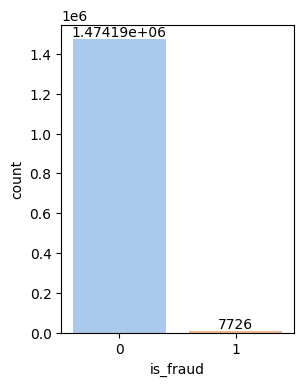

In [ ]:
# Unbalance data represented with bars.
plt.figure(figsize = (3,4))
ax = sns.countplot(x = 'is_fraud', data = df_train, palette = "pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
# Percentage of data.
print('Genuine transactions:', round(df_train['is_fraud'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Fraudulent transactions:', round(df_train['is_fraud'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

Genuine transactions: 99.48 % of the dataset
Fraudulent transactions: 0.52 % of the dataset


In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------> Unbalanced data check was finished <--------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------> Exploratory Data Analysis <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# A quick statistical summary of the columns was made.
np.round(df_train.describe(), 2)

,amount(usd),zip,lat,long,city_pop,unix_time,merch_lat,merch_long
count,1481915.00,1481915.00,1481915.00,1481915.00,1481915.00,1.481915e+06,1481915.00,1481915.00
mean,70.10,48807.52,38.54,-90.22,88719.66,1.358664e+09,38.54,-90.22
std,157.52,26880.75,5.07,13.75,301748.44,1.820019e+07,5.11,13.76
min,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67
25%,9.65,26237.00,34.67,-96.80,741.00,1.342996e+09,34.74,-96.89
50%,47.49,48174.00,39.35,-87.48,2443.00,1.357082e+09,39.37,-87.44
75%,83.14,72042.00,41.94,-80.16,20328.00,1.374569e+09,41.96,-80.24
max,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95


In [ ]:
# Quick Summarize using pandas_profiling was realized.
groups = [pd.Grouper(key="transaction_time", freq="1W"), "is_fraud"]
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

In [ ]:
def add_traces(df, x, y,hue, mode, cmap, showlegend=None):
    name_map = {1:"Yes", 0:"No"}
    traces = []
    for flag in df[hue].unique():
        traces.append(
            go.Scatter(
                x=df[df[hue]==flag][x],
                y=df[df[hue]==flag][y],
                mode=mode,
                marker=dict(color=cmap[flag]),
                showlegend=showlegend,
                name=name_map[flag]
            )
        )
    return traces

In [ ]:
fig = make_subplots(rows=2, cols=2,
                    specs=[
                        [{}, {}],
                        [{"colspan":2}, None]
                    ],
                    subplot_titles=("Amount(usd) over time", "Number of transactions overtime",
                                    "Number of transaction by amount(usd)")
                   )

ntraces = add_traces(df=df_,x='transaction_time',y='amount(usd)',hue='is_fraud',mode='lines',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])

for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=1
    )
    
ntraces = add_traces(df=df_,x='transaction_time',y='transaction_id',hue='is_fraud',mode='lines',
                    showlegend=False, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=2
    )

ntraces = add_traces(df=df_,x='transaction_id',y='amount(usd)',hue='is_fraud',mode='markers',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=2,col=1
    )

fig.update_layout(height=780,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa',
                  title='Overview'
                 )

fig.show()

In [ ]:
# The category of the fraudulent transactions was plotted.
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),
                           'is_fraud','category']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='category',
        facet_col_wrap=3,
        facet_col_spacing=.04,
        color_discrete_map={0:'#61E50F', 1:'#D93C1D'}
)
fig.update_layout(height=1400,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))
fig.show();

In [ ]:
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1M"),
                           'is_fraud','category']).agg({"amount(usd)":'sum',"transaction_id":"count"}).reset_index()
fig = px.area(
    df_[df_.is_fraud==1],
    x='transaction_time',
    y='amount(usd)',
    color='category',
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(height=600,
                  width=960,
                  legend=dict(title='Type of business'),
                  plot_bgcolor='#fafafa'
                 )
fig.show();

In [ ]:
# Specified list of 10 business with the highest number of transactions.
top12_merchants = df_train.merchant.value_counts()[:12]
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),'is_fraud',
                           'merchant']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()
df_ = df_[df_.merchant.isin(top12_merchants.index)]
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='merchant',
        facet_col_wrap=3,
        facet_col_spacing=.06,
        category_orders={'merchant': top12_merchants.index}, # order the subplots
        color_discrete_map={1:'#61E50F', 0:'#D93C1D'}
)
fig.update_layout(height=1200,
                  width=960,
                  title='Top 12 merchants with highest number of transactions per week',
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))
fig.show();

In [ ]:
# Top 10 jobs had most fraud transactions.
groups = ['is_fraud','job']
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_ = df_[df_.is_fraud==1].sort_values(by='transaction_id',
                                       ascending=False).drop_duplicates('job', keep='first').iloc[:10, :]
df_

,is_fraud,job,amount(usd),transaction_id
880,1,Quantity surveyor,678.778704,54
806,1,Naval architect,689.476852,54
784,1,Materials engineer,559.441538,52
843,1,Podiatrist,448.335319,47
539,1,Audiological scientist,639.151333,45
977,1,Trading standards officer,465.482955,44
691,1,Film/video editor,507.837907,43
685,1,Exhibition designer,551.193488,43
918,1,Senior tax professional/tax inspector,581.038837,43
527,1,Archaeologist,377.083250,40


In [ ]:
# The professions with the highest amount of fraudulent transactions were plotted.
fig = px.bar(df_,
             y='job', x='transaction_id',
             color='amount(usd)',
             color_continuous_scale=px.colors.sequential.Magma,
             labels={'job':'Job title', 
                     'transaction_id': 'Number of fraud transactions'},
             category_orders = {"job": df_.job.values},
             width=960,
             height=600)

fig.update_layout(
    title=dict(
        text='Amount in USD among top 10 jobs with the most fraud transactions'
    ),
    plot_bgcolor='#fafafa'
)

fig.update_coloraxes(
    colorbar=dict(
        title='Amount(usd) of transactions',
        orientation='h',
        x=1
    ),
    reversescale=True
)

fig.show()

In [ ]:
# Plotting the credit card numbers and card holders with the highest amount of fraudulent transactions.
groups = ['credit_card_number']
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_.sort_values('transaction_id', ascending=False, inplace=True)
df_ = df_.head(10)

In [ ]:
df_ = df_train[df_train.is_fraud==1].groupby(by='hour_of_day').agg({'transaction_id':'count'}).reset_index()

fig = px.bar(data_frame=df_,
       x='hour_of_day',
       y='transaction_id',
       labels={'transaction_id':'Number of transaction'})

fig.update_layout(
    title=dict(
        text='Number of FRAUD transactions by hours of day'
    ),
    plot_bgcolor='#fafafa'
)

fig.update_xaxes(type='category')

In [ ]:
# The correlations of each variable were checked.

/var/folders/1p/27jszvps12x14r9hnwf07w240000gn/T/ipykernel_90998/60512005.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/1p/27jszvps12x14r9hnwf07w240000gn/T/ipykernel_90998/60512005.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

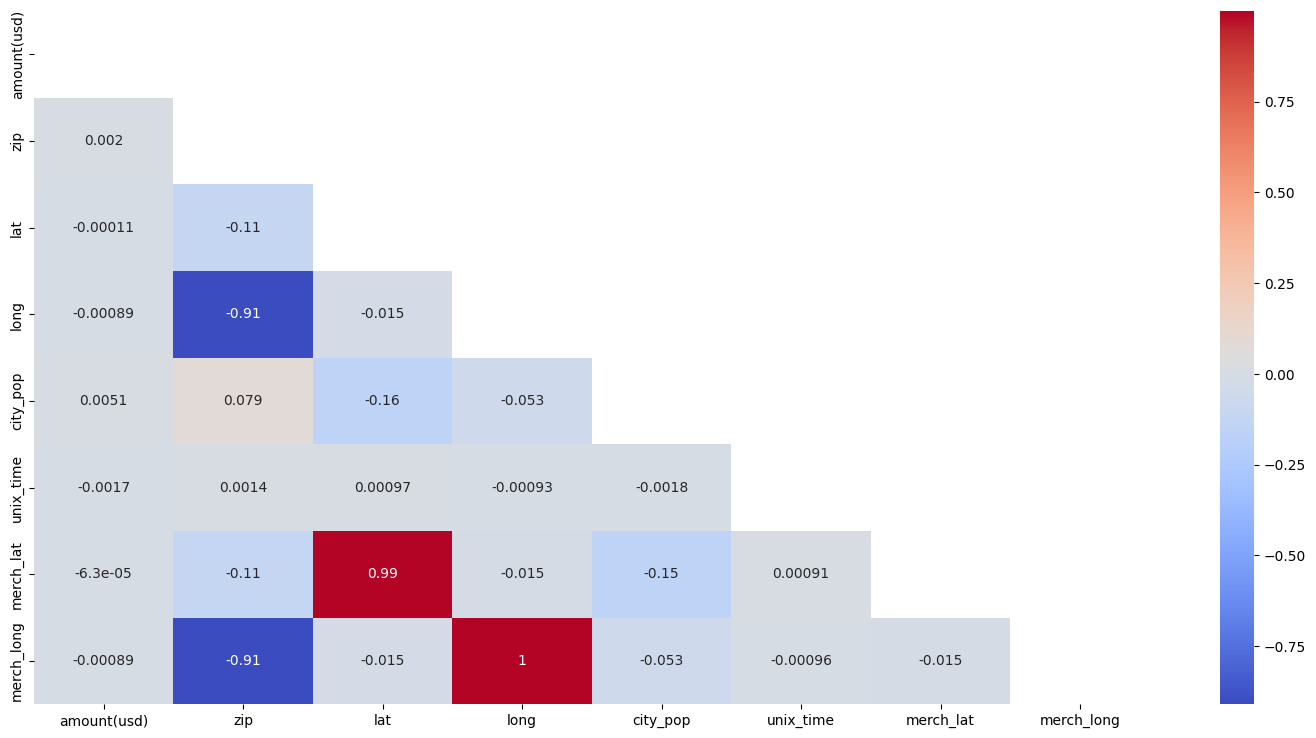

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (18,9))
mask = np.triu(np.ones_like(df_train.corr()))
sns.heatmap(df_train.corr(), mask = mask, cmap = 'coolwarm', annot = True)